In [1]:
%cd ..

d:\Linux\10_DRL\Code\Project\Final_Word-level


In [2]:
%ls

 Volume in drive D is Mjnk
 Volume Serial Number is 5A8E-8B70

 Directory of d:\Linux\10_DRL\Code\Project\Final_Word-level

07/02/2024  04:40 AM    <DIR>          .
06/16/2024  10:56 PM    <DIR>          ..
04/05/2024  08:52 PM                 0 __init__.py
06/27/2024  07:50 PM    <DIR>          Data
06/27/2024  08:48 PM    <DIR>          Images
07/01/2024  07:45 PM    <DIR>          Model
07/02/2024  04:57 AM    <DIR>          Notebook
07/02/2024  04:40 AM    <DIR>          Report
06/03/2024  07:48 PM               136 requirement.txt
06/10/2024  04:41 PM    <DIR>          src
               2 File(s)            136 bytes
               8 Dir(s)  86,277,763,072 bytes free


In [3]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import tqdm

import torch
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report

from src.utils import *
from src.model import *
from src.env import *

phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device:', device)

c:\Users\royal\miniconda3\envs\ml\lib\site-packages\transformers\utils\generic.py:481: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\royal\miniconda3\envs\ml\lib\site-packages\transformers\utils\generic.py:338: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\royal\miniconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads 

Current device: cuda


# Import data

In [4]:
import pandas as pd

data_name = 'UIT-VSFC'
data_folder_path = './Data/' + data_name + '/'

def read_data(folder_path):
    sentiments_df = pd.read_csv(folder_path + 'sentiments.txt', sep=' ', header=None, names=['sentiment'])
    try:
        sents_df = pd.read_csv(folder_path + 'sents.txt', sep=',', header=None)
    except pd.errors.ParserError:
        with open(folder_path + 'sents.txt', 'r') as file:
            lines = file.readlines()
            data = [line.strip() for line in lines]
        sents_df = pd.DataFrame(data, columns=['sentence'])
    
    data_df = pd.concat([sents_df, sentiments_df], axis=1)
    return data_df

In [5]:
train_data = read_data(data_folder_path + 'train/')
val_data = read_data(data_folder_path + 'dev/')
test_data = read_data(data_folder_path + 'test/')

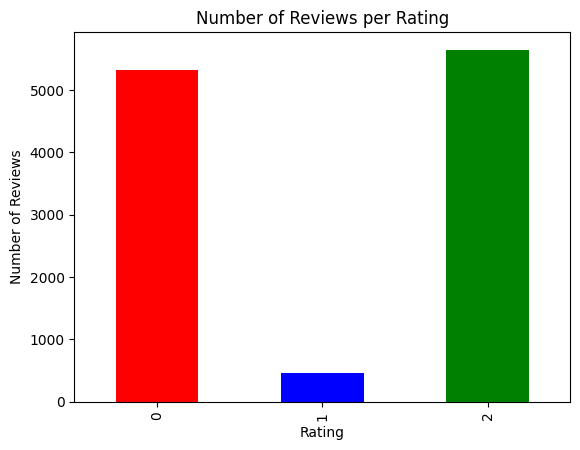

In [6]:
train_data['sentiment'].value_counts().sort_index().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Rating')
plt.show()

In [7]:
label_frequencies = train_data['sentiment'].value_counts(normalize=True).to_dict()
label_frequencies

{2: 0.4938736215648521, 0: 0.46604235953089446, 1: 0.040084018904253456}

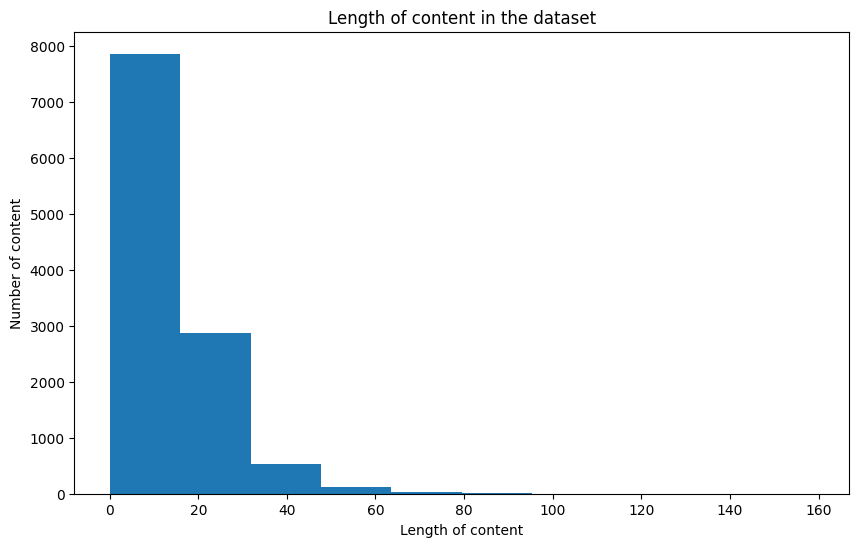

count    11426.000000
mean        14.308769
std         10.089727
min          2.000000
25%          8.000000
50%         11.000000
75%         17.000000
max        159.000000
Name: sentence, dtype: float64


In [8]:
content_lengths = train_data['sentence'].apply(lambda x: len(x.split()))
content_lengths.plot(kind='hist', bins=int(content_lengths.std()), range=(0, int(content_lengths.max())), figsize=(10, 6))
plt.xlabel('Length of content')
plt.ylabel('Number of content')
plt.title('Length of content in the dataset')
plt.show()

print(content_lengths.describe())

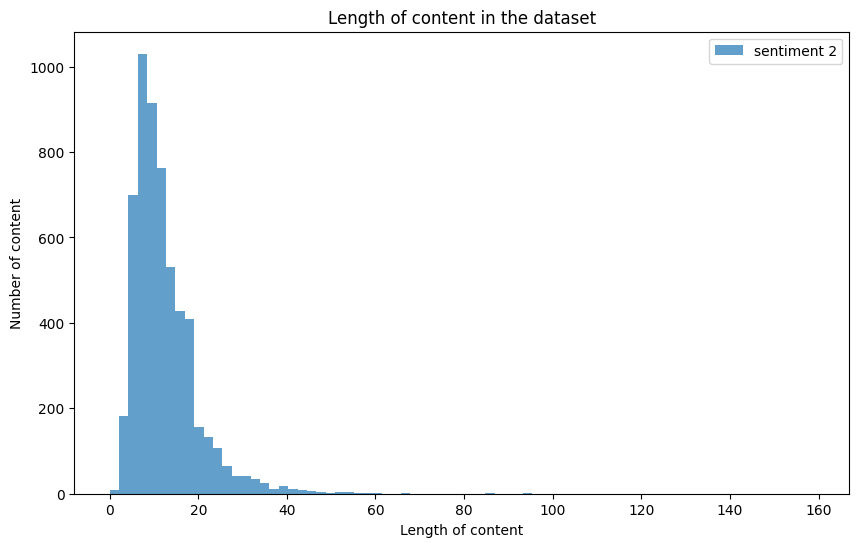

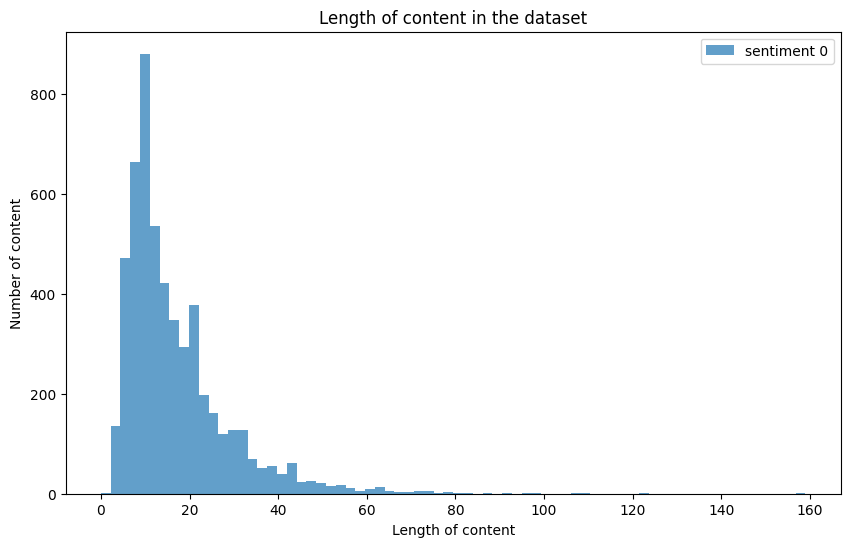

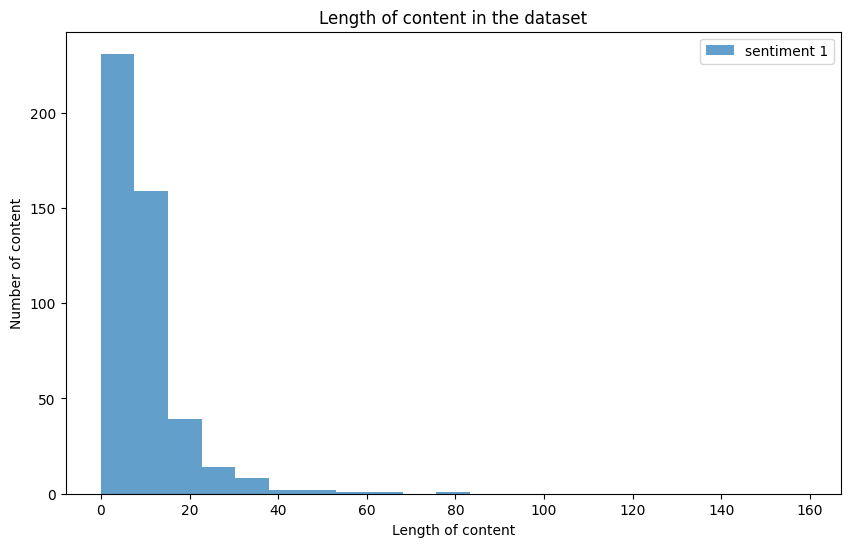

In [9]:
train_data['content_length'] = train_data['sentence'].apply(lambda x: len(x.split()))

max_content_length = train_data['content_length'].max()  # Define the maximum content length

for i in train_data['sentiment'].unique():  # Iterate over unique sentiment values directly
    plt.figure(figsize=(10, 6))
    # Optional: Consider a different approach for determining bins, e.g., fixed number or sqrt rule
    length_bins = int(np.sqrt(len(train_data[train_data['sentiment'] == i])))  # Example alternative
    plt.hist(train_data[train_data['sentiment'] == i]['content_length'], bins=length_bins, alpha=0.7, label=f'sentiment {i}', range=(0, max_content_length))
    plt.xlabel('Length of content')
    plt.ylabel('Number of content')
    plt.title('Length of content in the dataset')
    plt.legend()
    plt.show()

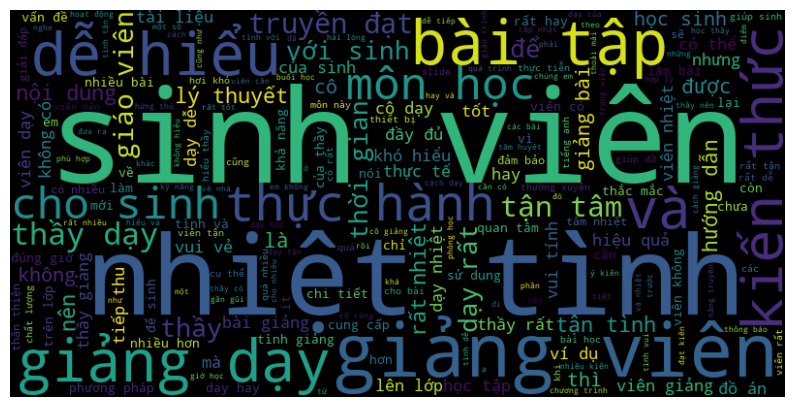

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(train_data['sentence']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Number of words in the dataset: 2514


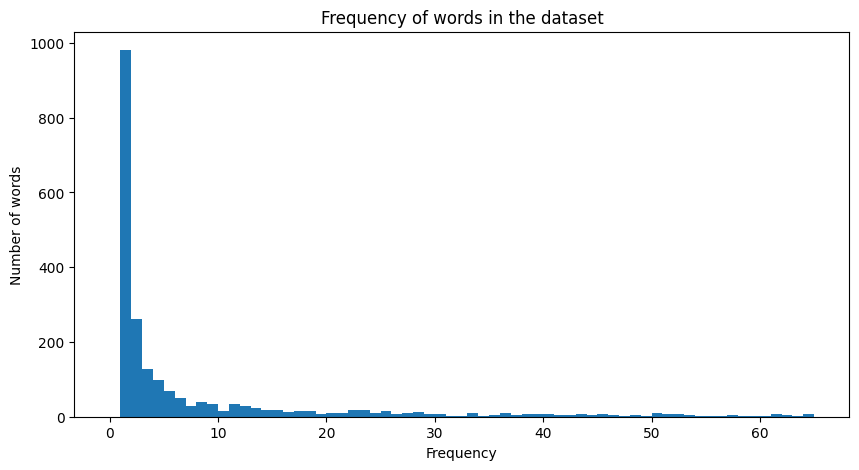

count     2514.000000
mean        65.032617
std        355.507534
min          1.000000
25%          1.000000
50%          3.000000
75%         20.000000
max      11009.000000
Name: frequency, dtype: float64


In [11]:
num_words = len(set(' '.join(train_data['sentence']).split()))
print('Number of words in the dataset:', num_words)

word_freq = Counter(' '.join(train_data['sentence']).split()).most_common(num_words)
word_freq_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])
word_freq_df['frequency'] = word_freq_df['frequency'].astype(int)
bins = int(word_freq_df['frequency'].mean())

word_freq_df['frequency'].plot(kind='hist', bins=bins, range=(0, bins), figsize=(10, 5))
plt.xlabel('Frequency')
plt.ylabel('Number of words')
plt.title('Frequency of words in the dataset')
plt.show()
print(word_freq_df['frequency'].describe())

## Vectorize

In [12]:
train_data = train_data.dropna()
test_data = test_data.dropna()
val_data = val_data.dropna()

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

MAX_LEN = 50
BATCH_SIZE = 64

encode_data = lambda x: tokenizer(x, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='pt')

train_data_comment = encode_data(train_data['sentence'].tolist())
test_data_comment = encode_data(test_data['sentence'].tolist())
val_data_comment = encode_data(val_data['sentence'].tolist())

train_labels = torch.tensor(train_data['sentiment']).long()
test_labels = torch.tensor(test_data['sentiment']).long()
val_labels = torch.tensor(val_data['sentiment']).long()

In [14]:
train_dataset = TensorDataset(train_data_comment['input_ids'], train_data_comment['attention_mask'], train_labels)
test_dataset = TensorDataset(test_data_comment['input_ids'], test_data_comment['attention_mask'], test_labels)
val_dataset = TensorDataset(val_data_comment['input_ids'], val_data_comment['attention_mask'], val_labels)

train_sampler = RandomSampler(train_dataset)
test_sampler = SequentialSampler(test_dataset)
val_sampler = SequentialSampler(val_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)

In [15]:
train_dataloader.dataset.tensors[0].shape, val_dataloader.dataset.tensors[0].shape, test_dataloader.dataset.tensors[0].shape

(torch.Size([11426, 50]), torch.Size([1583, 50]), torch.Size([3166, 50]))

In [16]:
encode_data = tokenizer.batch_encode_plus(train_data['sentence'].values.tolist(), 
                                          max_length=MAX_LEN, 
                                          truncation=True,
                                          padding='max_length', 
                                          return_tensors='pt')

indexs, counts = np.unique(encode_data['input_ids'], return_counts=True)

print('Percent of UNK token:', counts[indexs == tokenizer.unk_token_id].sum() / np.sum(counts) * 100)
print('Percent of PAD token:', counts[indexs == tokenizer.pad_token_id].sum() / np.sum(counts) * 100)
print('Percent of CLS token:', counts[indexs == tokenizer.cls_token_id].sum() / np.sum(counts) * 100)

Percent of UNK token: 0.0007001575354454753
Percent of PAD token: 67.22037458428146
Percent of CLS token: 2.0


In [17]:
class AgentRLSentimentClassifier:
    """
    A reinforcement learning agent for sentiment classification.
    """

    def __init__(self, num_class, 
                 actor_critic_net: ActorCriticNet, classifier_net: Classifier, feature_extracter,
                 lr_actor_critic=1e-3, lr_classifier=1e-3, gamma=0.99, device='cpu'):
        
        self.num_class = num_class

        self.actor_critic_net = actor_critic_net
        self.classifier_net = classifier_net
        self.feature_extracter = feature_extracter

        self.optimizer_actor_critic = optim.RMSprop(actor_critic_net.parameters(), lr=lr_actor_critic, weight_decay=1e-5)
        self.optimizer_classifier = optim.Adam(classifier_net.parameters(), lr=lr_classifier, weight_decay=1e-5)

        self.gamma = gamma
        self.device = device
        self.epsilon = 1
        self.epsilon_decay = 0.9
    
    def step(self, batches_sentence: torch.Tensor, batches_label: torch.Tensor, batches_attention_mask: torch.Tensor, training=True):
        eps = self.epsilon if training else 0

        batches_label = batches_label.to(self.device)
        with torch.no_grad():
            batches_sentence_embedding = self.feature_extracter(batches_sentence.to(self.device, dtype=torch.long), \
                                                                attention_mask=batches_attention_mask.to(self.device, dtype=torch.long))[0]
        batch_size, max_len = batches_sentence.shape

        noise = torch.randn_like(batches_sentence_embedding) * 0.1
        values, policy = self.actor_critic_net(batches_sentence_embedding + noise) # (batch_size, max_len, 1) and (batch_size, max_len, num_actions)
        action = self._choose_action(policy, eps)
        
        filtered_batches_sentence_embedding = batches_sentence_embedding * action.unsqueeze(-1) + noise
        next_values, _ = self.actor_critic_net(filtered_batches_sentence_embedding)

        classifier_preds = self.classifier_net(filtered_batches_sentence_embedding)

        correct_predictions = (classifier_preds.argmax(dim=-1) == batches_label).float()
        rewards = self._get_reward(classifier_preds, batches_label).unsqueeze(-1).unsqueeze(-1)

        with torch.no_grad():  # Don't backpropagate through target calculation
            td_target = rewards + self.gamma * next_values 
        
        advantage = td_target - values 
        log_probs = torch.log(policy) # Log probs for chosen actions
        actor_loss = -torch.sum(log_probs * action.unsqueeze(-1), dim=-1)
        actor_loss = (actor_loss.unsqueeze(-1) * advantage.detach()).mean()  
        critic_loss = F.mse_loss(values, td_target)
        actor_critic_loss = actor_loss + critic_loss

        class_weight = 0.1  # Smoothing factor
        smoothed_labels = (1.0 - class_weight) * F.one_hot(batches_label, num_classes=self.num_class).float() + class_weight / 3
        classifier_loss = F.cross_entropy(classifier_preds, smoothed_labels)

        accuracy = correct_predictions.mean()
        
        return actor_critic_loss, classifier_loss, accuracy, rewards.mean().item()
    
    def _choose_action(self, policy, epsilon):
        if np.random.rand() < epsilon:
            return torch.randint(0, policy.shape[-1], policy.shape[:-1]).to(self.device)
        
        return torch.distributions.Categorical(policy).sample()

    def _get_reward(self, predicted_probs, true_labels):
        true_class_probs = F.one_hot(true_labels, num_classes=self.num_class).float()
        rewards = -F.kl_div(predicted_probs, true_class_probs, reduction='batchmean')#.sum(dim=-1)
        # print(rewards)
        return rewards     

    def train(self, train_dataloader, val_dataloader, n_epochs=10):
        best_val_loss = float('inf')
        epoch = 0
        self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards = [], [], [], []
        self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards = [], [], [], []
        while epoch < n_epochs:
            print('-' * 50)
            print(f'Epoch: {epoch + 1} / {n_epochs}')
            self.actor_critic_net.train()
            self.classifier_net.train()
            running_ac_loss, running_classifier_loss, running_accuracy, running_reward = 0.0, 0.0, 0.0, 0.0
            for i, data in enumerate(tqdm.tqdm(train_dataloader), 0):
                ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1])

                self.optimizer_actor_critic.zero_grad()
                ac_loss.backward()
                self.optimizer_actor_critic.step()

                # total_loss = ac_loss + classifier_loss
                # total_loss.backward()

                if epoch % 2 == 0:
                    self.optimizer_classifier.zero_grad()
                    classifier_loss.backward()
                    self.optimizer_classifier.step()

                running_ac_loss += ac_loss.item()
                running_classifier_loss += classifier_loss.item()
                running_accuracy += accuracy
                running_reward += reward

                torch.cuda.empty_cache()
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)
            
            self.training_classifier_losses.append(running_classifier_loss / len(train_dataloader))
            self.training_ac_losses.append(running_ac_loss / len(train_dataloader))
            self.training_accuracies.append(running_accuracy / len(train_dataloader))
            self.training_rewards.append(running_reward / len(train_dataloader))

            self.actor_critic_net.eval()
            self.classifier_net.eval()
            val_ac_loss, val_classifier_loss, val_accuracy, val_reward = 0.0, 0.0, 0.0, 0.0
            with torch.no_grad():
                for i, data in enumerate(val_dataloader, 0):
                    ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1], training=False)
                    val_ac_loss += ac_loss.item()
                    val_classifier_loss += classifier_loss.item()
                    val_accuracy += accuracy
                    val_reward += reward

                    torch.cuda.empty_cache()

            self.val_classifier_losses.append(val_classifier_loss / len(val_dataloader))
            self.val_ac_losses.append(val_ac_loss / len(val_dataloader))
            self.val_accuracies.append(val_accuracy / len(val_dataloader))
            self.val_rewards.append(val_reward / len(val_dataloader))

            print(f'Training AC Loss: {running_ac_loss / len(train_dataloader) :.2f}, Training Classifier Loss: {running_classifier_loss / len(train_dataloader) :.2f}, Training Accuracy: {running_accuracy / len(train_dataloader) :.2f}, Training Reward: {running_reward / len(train_dataloader) :.2f}, Epsilon: {self.epsilon:.2f}')
            print(f'Validation AC Loss: {val_ac_loss / len(val_dataloader) :.2f}, Validation Classifier Loss: {val_classifier_loss / len(val_dataloader) :.2f}, Validation Accuracy: {val_accuracy / len(val_dataloader) :.2f}, Validation Reward: {val_reward / len(val_dataloader) :.2f}')

            if val_classifier_loss < best_val_loss:
                best_val_loss = val_classifier_loss
                torch.save(self.actor_critic_net.state_dict(), './Model/actor_critic_model.pth')
                torch.save(self.classifier_net.state_dict(), './Model/classifier_model.pth')
                print('Model saved.')
            
            epoch += 1

        print('Finished Training')
        torch.cuda.empty_cache()
        return self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards, \
               self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards

In [18]:
from sklearn.metrics import f1_score

class AgentRLSentimentClassifier:
    """
    A reinforcement learning agent for sentiment classification.
    """

    def __init__(self, num_class, 
                 actor_net: ActorNet, critic_classifier_net: CriticClassifierNet, feature_extracter,
                 lr_actor_critic=1e-3, lr_classifier=1e-3, gamma=0.99, device='cpu'):
        
        self.num_class = num_class

        self.actor_net = actor_net
        self.critic_classifier_net = critic_classifier_net
        self.feature_extracter = feature_extracter

        self.optimizer_actor_net = optim.RMSprop(self.actor_net.parameters(), lr=lr_actor_critic, weight_decay=1e-5)
        self.optimizer_critic_classifier = optim.Adam(self.critic_classifier_net.parameters(), lr=lr_classifier, weight_decay=1e-5)

        self.gamma = gamma
        self.device = device
        self.epsilon = 1
        self.epsilon_decay = 0.9

        self.reward_weights = self._calculate_reward_weights().to(device)
        print('Reward weights:', self.reward_weights)
    
    def _calculate_reward_weights(self):
        # Assuming label_frequencies is defined and accessible
        total_samples = sum(label_frequencies.values())
        reward_weights = torch.tensor([total_samples / (label_frequencies[label] * len(label_frequencies)) 
                                       for label in sorted(label_frequencies)], dtype=torch.float)
        reward_weights /= reward_weights.max()
        return reward_weights
    
    def step(self, 
             batches_sentence: torch.Tensor, 
             batches_label: torch.Tensor, 
             batches_attention_mask: torch.Tensor, 
             training=True) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
        eps = self.epsilon if training else 0

        batches_label = batches_label.to(self.device)
        with torch.no_grad():
            batches_sentence_embedding = self.feature_extracter(batches_sentence.to(self.device, dtype=torch.long), \
                                                                attention_mask=batches_attention_mask.to(self.device, dtype=torch.long))[0]

        policy = self.actor_net.forward(batches_sentence_embedding)
        values, _ = self.critic_classifier_net.forward(batches_sentence_embedding)
        action = self._choose_action(policy, eps)
        
        filtered_batches_sentence_embedding = batches_sentence_embedding * action.unsqueeze(-1).float()
        # filtered_batches_sentence_embedding = action.unsqueeze(-1).float()
        next_values, classifier_probs = self.critic_classifier_net.forward(filtered_batches_sentence_embedding)

        classifier_loss = F.cross_entropy(classifier_probs, batches_label)

        correct_predictions = (classifier_probs.argmax(dim=-1) == batches_label).float()
        accuracy = correct_predictions.mean()

        with torch.no_grad():
            rewards = self._get_reward(correct_predictions, batches_label)
            td_target = rewards + self.gamma * next_values.detach()
            
        advantage = td_target - values
        actor_loss = -(policy.log() * action.unsqueeze(-1)).sum(dim=-1)
        actor_loss = (actor_loss.unsqueeze(-1) * advantage.detach()).mean()
        actor_critic_loss = actor_loss + classifier_loss
        
        return actor_critic_loss, classifier_loss, accuracy, rewards.mean().item()
    
    def _choose_action(self, policy, epsilon):
        if np.random.rand() < epsilon:
            return torch.randint(0, policy.shape[-1], policy.shape[:-1], device=self.device)
        return torch.distributions.Categorical(policy).sample()

    def _get_reward(self, correct_predictions, true_labels) -> torch.Tensor:
        true_labels_list = true_labels.tolist()
        rewards = correct_predictions * self.reward_weights[true_labels_list] - 1
        return rewards
    
    def evaluate(self, dataloader):
        self.actor_net.eval()
        self.critic_classifier_net.eval()
        running_ac_loss, running_classifier_loss, running_accuracy, running_reward = 0.0, 0.0, 0.0, 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1], training=False)
                running_ac_loss += ac_loss.item()
                running_classifier_loss += classifier_loss.item()
                running_accuracy += accuracy
                running_reward += reward

                preds = self.critic_classifier_net.forward(self.feature_extracter(data[0].to(self.device, dtype=torch.long), \
                                                                                       attention_mask=data[1].to(self.device, dtype=torch.long))[0])[1].argmax(dim=-1).tolist()

                y_true.extend(data[2].tolist())
                y_pred.extend(preds)

                torch.cuda.empty_cache()

        f1 = f1_score(y_true, y_pred, average='macro')

        return running_ac_loss / len(dataloader), \
               running_classifier_loss / len(dataloader), \
               running_accuracy / len(dataloader), \
               running_reward / len(dataloader), \
               f1

    def train(self, train_dataloader, val_dataloader, n_epochs=10):
        best_val_loss = float('inf')
        epoch = 0
        self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards = [], [], [], []
        self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards = [], [], [], []
        while epoch < n_epochs:
            print('-' * 50)
            print(f'Epoch: {epoch + 1} / {n_epochs}')

            # ---------------------- Training ---------------------- #
            self.actor_net.train()
            self.critic_classifier_net.train()
            running_ac_loss, running_classifier_loss, running_accuracy, running_reward = 0.0, 0.0, 0.0, 0.0
            for i, data in enumerate(tqdm.tqdm(train_dataloader), 0):
                ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1])

                self.optimizer_actor_net.zero_grad()
                self.optimizer_critic_classifier.zero_grad()
                # ac_loss.backward()

                total_loss = ac_loss + classifier_loss
                total_loss.backward()

                self.optimizer_actor_net.step()
                self.optimizer_critic_classifier.step()

                running_ac_loss += ac_loss.item()
                running_classifier_loss += classifier_loss.item()
                running_accuracy += accuracy
                running_reward += reward

                torch.cuda.empty_cache()
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)
            
            self.training_classifier_losses.append(running_classifier_loss / len(train_dataloader))
            self.training_ac_losses.append(running_ac_loss / len(train_dataloader))
            self.training_accuracies.append(running_accuracy / len(train_dataloader))
            self.training_rewards.append(running_reward / len(train_dataloader))

            # ---------------------- Validation ---------------------- #
            val_ac_loss, val_classifier_loss, val_accuracy, val_reward, val_f1 = self.evaluate(val_dataloader)

            self.val_classifier_losses.append(val_classifier_loss)
            self.val_ac_losses.append(val_ac_loss)
            self.val_accuracies.append(val_accuracy)
            self.val_rewards.append(val_reward)


            print(f'Training AC Loss: {running_ac_loss / len(train_dataloader) :.2f}, Training Classifier Loss: {running_classifier_loss / len(train_dataloader) :.2f}, Training Accuracy: {running_accuracy / len(train_dataloader) :.2f}, Training Reward: {running_reward / len(train_dataloader) :.2f}, Epsilon: {self.epsilon:.2f}')
            print(f'Validation AC Loss: {val_ac_loss :.2f}, Validation Classifier Loss: {val_classifier_loss :.2f}, Validation Accuracy: {val_accuracy :.2f}, Validation Reward: {val_reward :.2f}, Validation F1: {val_f1 :.2f}')

            if val_classifier_loss < best_val_loss:
                best_val_loss = val_classifier_loss
                torch.save(self.actor_net.state_dict(), './Model/actor_model_'+ data_name +'.pth')
                torch.save(self.critic_classifier_net.state_dict(), './Model/critic_classifier_model_'+ data_name +'.pth')
                print('Model saved.')
            
            epoch += 1

        print('Finished Training')
        torch.cuda.empty_cache()
        return self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards, \
               self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards

In [19]:
# num_class = 3
# actor_critic_net = ActorCriticNet(input_dim=768, output_dim=2).to(device)
# classifier_net = Classifier(input_dim=768, output_dim=num_class).to(device)
# feature_extracter = phobert.to(device)
# feature_extracter.eval()

# agent = AgentRLSentimentClassifier(num_class=num_class, actor_critic_net=actor_critic_net, classifier_net=classifier_net, feature_extracter=feature_extracter, device=device, 
#                                    lr_actor_critic=1e-4, lr_classifier=1e-5, gamma=0.999)

In [20]:
num_class = 3
actor_net = ActorNet(input_dim=768, output_dim=2).to(device)
critic_classifier_net = CriticClassifierNet(input_dim=768, seq_len=MAX_LEN, output_dim=num_class).to(device)
feature_extracter = phobert.to(device)
feature_extracter.eval()

agent = AgentRLSentimentClassifier(num_class=num_class, actor_net=actor_net, critic_classifier_net=critic_classifier_net, 
                                   feature_extracter=feature_extracter, device=device, 
                                   lr_actor_critic=1e-5, lr_classifier=2e-5, gamma=0.999)

Reward weights: tensor([0.0860, 1.0000, 0.0812], device='cuda:0')


In [89]:
training_ac_losses, training_classifier_losses, training_accuracy, training_rewards, \
val_ac_losses, val_classifier_losses, val_accuracy, val_rewards = agent.train(train_dataloader,
                                                                              val_dataloader,
                                                                              n_epochs=50)

--------------------------------------------------
Epoch: 1 / 50


100%|██████████| 179/179 [00:26<00:00,  6.84it/s]


Training AC Loss: -2.39, Training Classifier Loss: 0.81, Training Accuracy: 0.62, Training Reward: -0.95, Epsilon: 0.90
Validation AC Loss: -7.99, Validation Classifier Loss: 0.62, Validation Accuracy: 0.80, Validation Reward: -0.93, Validation F1: 0.55
Model saved.
--------------------------------------------------
Epoch: 2 / 50


100%|██████████| 179/179 [00:26<00:00,  6.78it/s]


Training AC Loss: -4.62, Training Classifier Loss: 0.44, Training Accuracy: 0.85, Training Reward: -0.93, Epsilon: 0.81
Validation AC Loss: -8.93, Validation Classifier Loss: 0.44, Validation Accuracy: 0.88, Validation Reward: -0.93, Validation F1: 0.60
Model saved.
--------------------------------------------------
Epoch: 3 / 50


100%|██████████| 179/179 [00:26<00:00,  6.85it/s]


Training AC Loss: -5.34, Training Classifier Loss: 0.37, Training Accuracy: 0.88, Training Reward: -0.93, Epsilon: 0.73
Validation AC Loss: -9.44, Validation Classifier Loss: 0.37, Validation Accuracy: 0.89, Validation Reward: -0.93, Validation F1: 0.60
Model saved.
--------------------------------------------------
Epoch: 4 / 50


100%|██████████| 179/179 [00:26<00:00,  6.76it/s]


Training AC Loss: -6.14, Training Classifier Loss: 0.33, Training Accuracy: 0.89, Training Reward: -0.93, Epsilon: 0.66
Validation AC Loss: -9.87, Validation Classifier Loss: 0.35, Validation Accuracy: 0.89, Validation Reward: -0.93, Validation F1: 0.62
Model saved.
--------------------------------------------------
Epoch: 5 / 50


100%|██████████| 179/179 [00:26<00:00,  6.70it/s]


Training AC Loss: -6.80, Training Classifier Loss: 0.32, Training Accuracy: 0.89, Training Reward: -0.93, Epsilon: 0.59
Validation AC Loss: -10.29, Validation Classifier Loss: 0.34, Validation Accuracy: 0.89, Validation Reward: -0.93, Validation F1: 0.62
Model saved.
--------------------------------------------------
Epoch: 6 / 50


100%|██████████| 179/179 [00:27<00:00,  6.59it/s]


Training AC Loss: -7.42, Training Classifier Loss: 0.31, Training Accuracy: 0.90, Training Reward: -0.92, Epsilon: 0.53
Validation AC Loss: -10.72, Validation Classifier Loss: 0.33, Validation Accuracy: 0.89, Validation Reward: -0.93, Validation F1: 0.62
Model saved.
--------------------------------------------------
Epoch: 7 / 50


100%|██████████| 179/179 [00:27<00:00,  6.47it/s]


Training AC Loss: -8.14, Training Classifier Loss: 0.29, Training Accuracy: 0.90, Training Reward: -0.92, Epsilon: 0.48
Validation AC Loss: -11.10, Validation Classifier Loss: 0.31, Validation Accuracy: 0.90, Validation Reward: -0.92, Validation F1: 0.66
Model saved.
--------------------------------------------------
Epoch: 8 / 50


100%|██████████| 179/179 [00:27<00:00,  6.44it/s]


Training AC Loss: -8.45, Training Classifier Loss: 0.28, Training Accuracy: 0.91, Training Reward: -0.92, Epsilon: 0.43
Validation AC Loss: -11.51, Validation Classifier Loss: 0.30, Validation Accuracy: 0.90, Validation Reward: -0.92, Validation F1: 0.68
Model saved.
--------------------------------------------------
Epoch: 9 / 50


100%|██████████| 179/179 [00:28<00:00,  6.39it/s]


Training AC Loss: -9.12, Training Classifier Loss: 0.27, Training Accuracy: 0.91, Training Reward: -0.92, Epsilon: 0.39
Validation AC Loss: -11.90, Validation Classifier Loss: 0.30, Validation Accuracy: 0.90, Validation Reward: -0.92, Validation F1: 0.71
Model saved.
--------------------------------------------------
Epoch: 10 / 50


100%|██████████| 179/179 [00:27<00:00,  6.43it/s]


Training AC Loss: -10.03, Training Classifier Loss: 0.26, Training Accuracy: 0.91, Training Reward: -0.92, Epsilon: 0.35
Validation AC Loss: -12.35, Validation Classifier Loss: 0.29, Validation Accuracy: 0.90, Validation Reward: -0.92, Validation F1: 0.71
Model saved.
--------------------------------------------------
Epoch: 11 / 50


100%|██████████| 179/179 [00:28<00:00,  6.32it/s]


Training AC Loss: -10.44, Training Classifier Loss: 0.26, Training Accuracy: 0.91, Training Reward: -0.92, Epsilon: 0.31
Validation AC Loss: -12.76, Validation Classifier Loss: 0.28, Validation Accuracy: 0.91, Validation Reward: -0.92, Validation F1: 0.72
Model saved.
--------------------------------------------------
Epoch: 12 / 50


100%|██████████| 179/179 [00:28<00:00,  6.25it/s]


Training AC Loss: -10.90, Training Classifier Loss: 0.25, Training Accuracy: 0.92, Training Reward: -0.92, Epsilon: 0.28
Validation AC Loss: -13.14, Validation Classifier Loss: 0.28, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
Model saved.
--------------------------------------------------
Epoch: 13 / 50


100%|██████████| 179/179 [00:29<00:00,  6.09it/s]


Training AC Loss: -11.89, Training Classifier Loss: 0.24, Training Accuracy: 0.92, Training Reward: -0.92, Epsilon: 0.25
Validation AC Loss: -13.65, Validation Classifier Loss: 0.29, Validation Accuracy: 0.90, Validation Reward: -0.92, Validation F1: 0.72
--------------------------------------------------
Epoch: 14 / 50


100%|██████████| 179/179 [00:28<00:00,  6.23it/s]


Training AC Loss: -11.82, Training Classifier Loss: 0.23, Training Accuracy: 0.92, Training Reward: -0.91, Epsilon: 0.23
Validation AC Loss: -14.10, Validation Classifier Loss: 0.28, Validation Accuracy: 0.90, Validation Reward: -0.92, Validation F1: 0.72
Model saved.
--------------------------------------------------
Epoch: 15 / 50


100%|██████████| 179/179 [00:29<00:00,  6.03it/s]


Training AC Loss: -12.65, Training Classifier Loss: 0.23, Training Accuracy: 0.92, Training Reward: -0.91, Epsilon: 0.21
Validation AC Loss: -14.51, Validation Classifier Loss: 0.27, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
Model saved.
--------------------------------------------------
Epoch: 16 / 50


100%|██████████| 179/179 [00:29<00:00,  6.09it/s]


Training AC Loss: -13.08, Training Classifier Loss: 0.22, Training Accuracy: 0.92, Training Reward: -0.91, Epsilon: 0.19
Validation AC Loss: -15.01, Validation Classifier Loss: 0.29, Validation Accuracy: 0.90, Validation Reward: -0.92, Validation F1: 0.73
--------------------------------------------------
Epoch: 17 / 50


100%|██████████| 179/179 [00:29<00:00,  6.10it/s]


Training AC Loss: -13.94, Training Classifier Loss: 0.22, Training Accuracy: 0.92, Training Reward: -0.91, Epsilon: 0.17
Validation AC Loss: -15.45, Validation Classifier Loss: 0.28, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 18 / 50


100%|██████████| 179/179 [00:29<00:00,  6.05it/s]


Training AC Loss: -14.28, Training Classifier Loss: 0.21, Training Accuracy: 0.93, Training Reward: -0.91, Epsilon: 0.15
Validation AC Loss: -15.77, Validation Classifier Loss: 0.27, Validation Accuracy: 0.91, Validation Reward: -0.90, Validation F1: 0.77
--------------------------------------------------
Epoch: 19 / 50


100%|██████████| 179/179 [00:29<00:00,  6.00it/s]


Training AC Loss: -14.71, Training Classifier Loss: 0.21, Training Accuracy: 0.93, Training Reward: -0.91, Epsilon: 0.14
Validation AC Loss: -16.41, Validation Classifier Loss: 0.27, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.73
--------------------------------------------------
Epoch: 20 / 50


100%|██████████| 179/179 [00:29<00:00,  6.07it/s]


Training AC Loss: -15.73, Training Classifier Loss: 0.20, Training Accuracy: 0.93, Training Reward: -0.91, Epsilon: 0.12
Validation AC Loss: -16.90, Validation Classifier Loss: 0.27, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.73
--------------------------------------------------
Epoch: 21 / 50


100%|██████████| 179/179 [00:29<00:00,  6.11it/s]


Training AC Loss: -15.94, Training Classifier Loss: 0.20, Training Accuracy: 0.93, Training Reward: -0.91, Epsilon: 0.11
Validation AC Loss: -17.31, Validation Classifier Loss: 0.28, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 22 / 50


100%|██████████| 179/179 [00:29<00:00,  6.09it/s]


Training AC Loss: -16.65, Training Classifier Loss: 0.19, Training Accuracy: 0.93, Training Reward: -0.91, Epsilon: 0.10
Validation AC Loss: -17.87, Validation Classifier Loss: 0.28, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.73
--------------------------------------------------
Epoch: 23 / 50


100%|██████████| 179/179 [00:29<00:00,  6.05it/s]


Training AC Loss: -17.19, Training Classifier Loss: 0.18, Training Accuracy: 0.94, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -18.31, Validation Classifier Loss: 0.27, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 24 / 50


100%|██████████| 179/179 [00:28<00:00,  6.37it/s]


Training AC Loss: -17.52, Training Classifier Loss: 0.18, Training Accuracy: 0.94, Training Reward: -0.91, Epsilon: 0.10
Validation AC Loss: -18.83, Validation Classifier Loss: 0.28, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 25 / 50


100%|██████████| 179/179 [00:28<00:00,  6.36it/s]


Training AC Loss: -17.89, Training Classifier Loss: 0.18, Training Accuracy: 0.94, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -19.33, Validation Classifier Loss: 0.28, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 26 / 50


100%|██████████| 179/179 [00:29<00:00,  6.05it/s]


Training AC Loss: -18.57, Training Classifier Loss: 0.17, Training Accuracy: 0.94, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -19.83, Validation Classifier Loss: 0.29, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 27 / 50


100%|██████████| 179/179 [00:29<00:00,  6.04it/s]


Training AC Loss: -19.14, Training Classifier Loss: 0.17, Training Accuracy: 0.94, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -20.29, Validation Classifier Loss: 0.28, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 28 / 50


100%|██████████| 179/179 [00:29<00:00,  6.02it/s]


Training AC Loss: -19.41, Training Classifier Loss: 0.16, Training Accuracy: 0.94, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -20.70, Validation Classifier Loss: 0.28, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.76
--------------------------------------------------
Epoch: 29 / 50


100%|██████████| 179/179 [00:29<00:00,  6.10it/s]


Training AC Loss: -19.41, Training Classifier Loss: 0.16, Training Accuracy: 0.94, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -21.38, Validation Classifier Loss: 0.29, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.73
--------------------------------------------------
Epoch: 30 / 50


100%|██████████| 179/179 [00:29<00:00,  6.08it/s]


Training AC Loss: -19.91, Training Classifier Loss: 0.16, Training Accuracy: 0.95, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -21.84, Validation Classifier Loss: 0.30, Validation Accuracy: 0.91, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 31 / 50


100%|██████████| 179/179 [00:29<00:00,  6.11it/s]


Training AC Loss: -20.57, Training Classifier Loss: 0.15, Training Accuracy: 0.95, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -22.32, Validation Classifier Loss: 0.31, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 32 / 50


100%|██████████| 179/179 [00:29<00:00,  6.11it/s]


Training AC Loss: -20.97, Training Classifier Loss: 0.14, Training Accuracy: 0.95, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -22.78, Validation Classifier Loss: 0.33, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.76
--------------------------------------------------
Epoch: 33 / 50


100%|██████████| 179/179 [00:29<00:00,  6.06it/s]


Training AC Loss: -21.82, Training Classifier Loss: 0.14, Training Accuracy: 0.95, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -23.33, Validation Classifier Loss: 0.35, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.76
--------------------------------------------------
Epoch: 34 / 50


100%|██████████| 179/179 [00:29<00:00,  6.16it/s]


Training AC Loss: -22.50, Training Classifier Loss: 0.13, Training Accuracy: 0.96, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -23.82, Validation Classifier Loss: 0.33, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.76
--------------------------------------------------
Epoch: 35 / 50


100%|██████████| 179/179 [00:29<00:00,  6.06it/s]


Training AC Loss: -22.46, Training Classifier Loss: 0.13, Training Accuracy: 0.96, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -24.42, Validation Classifier Loss: 0.34, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 36 / 50


100%|██████████| 179/179 [00:28<00:00,  6.19it/s]


Training AC Loss: -23.42, Training Classifier Loss: 0.12, Training Accuracy: 0.96, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -24.94, Validation Classifier Loss: 0.36, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 37 / 50


100%|██████████| 179/179 [00:28<00:00,  6.34it/s]


Training AC Loss: -23.14, Training Classifier Loss: 0.12, Training Accuracy: 0.96, Training Reward: -0.90, Epsilon: 0.10
Validation AC Loss: -25.37, Validation Classifier Loss: 0.35, Validation Accuracy: 0.89, Validation Reward: -0.91, Validation F1: 0.76
--------------------------------------------------
Epoch: 38 / 50


100%|██████████| 179/179 [00:28<00:00,  6.36it/s]


Training AC Loss: -24.18, Training Classifier Loss: 0.11, Training Accuracy: 0.96, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -26.00, Validation Classifier Loss: 0.36, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 39 / 50


100%|██████████| 179/179 [00:28<00:00,  6.36it/s]


Training AC Loss: -24.98, Training Classifier Loss: 0.10, Training Accuracy: 0.97, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -26.53, Validation Classifier Loss: 0.40, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 40 / 50


100%|██████████| 179/179 [00:28<00:00,  6.36it/s]


Training AC Loss: -24.70, Training Classifier Loss: 0.10, Training Accuracy: 0.97, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -27.09, Validation Classifier Loss: 0.42, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.73
--------------------------------------------------
Epoch: 41 / 50


100%|██████████| 179/179 [00:28<00:00,  6.34it/s]


Training AC Loss: -25.79, Training Classifier Loss: 0.09, Training Accuracy: 0.97, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -27.62, Validation Classifier Loss: 0.42, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 42 / 50


100%|██████████| 179/179 [00:28<00:00,  6.36it/s]


Training AC Loss: -26.45, Training Classifier Loss: 0.09, Training Accuracy: 0.97, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -28.17, Validation Classifier Loss: 0.46, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 43 / 50


100%|██████████| 179/179 [00:28<00:00,  6.35it/s]


Training AC Loss: -26.89, Training Classifier Loss: 0.09, Training Accuracy: 0.97, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -28.75, Validation Classifier Loss: 0.46, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.73
--------------------------------------------------
Epoch: 44 / 50


100%|██████████| 179/179 [00:28<00:00,  6.36it/s]


Training AC Loss: -27.31, Training Classifier Loss: 0.08, Training Accuracy: 0.97, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -29.18, Validation Classifier Loss: 0.46, Validation Accuracy: 0.89, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 45 / 50


100%|██████████| 179/179 [00:28<00:00,  6.35it/s]


Training AC Loss: -27.13, Training Classifier Loss: 0.09, Training Accuracy: 0.97, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -29.78, Validation Classifier Loss: 0.46, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
--------------------------------------------------
Epoch: 46 / 50


100%|██████████| 179/179 [00:28<00:00,  6.35it/s]


Training AC Loss: -28.53, Training Classifier Loss: 0.07, Training Accuracy: 0.98, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -30.37, Validation Classifier Loss: 0.51, Validation Accuracy: 0.89, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 47 / 50


100%|██████████| 179/179 [00:28<00:00,  6.24it/s]


Training AC Loss: -28.79, Training Classifier Loss: 0.07, Training Accuracy: 0.98, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -30.89, Validation Classifier Loss: 0.52, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 48 / 50


100%|██████████| 179/179 [00:28<00:00,  6.34it/s]


Training AC Loss: -28.95, Training Classifier Loss: 0.07, Training Accuracy: 0.98, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -31.45, Validation Classifier Loss: 0.54, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 49 / 50


100%|██████████| 179/179 [00:29<00:00,  6.05it/s]


Training AC Loss: -29.56, Training Classifier Loss: 0.08, Training Accuracy: 0.98, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -32.12, Validation Classifier Loss: 0.50, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.74
--------------------------------------------------
Epoch: 50 / 50


100%|██████████| 179/179 [00:29<00:00,  6.10it/s]


Training AC Loss: -30.00, Training Classifier Loss: 0.07, Training Accuracy: 0.98, Training Reward: -0.89, Epsilon: 0.10
Validation AC Loss: -32.60, Validation Classifier Loss: 0.55, Validation Accuracy: 0.90, Validation Reward: -0.91, Validation F1: 0.75
Finished Training


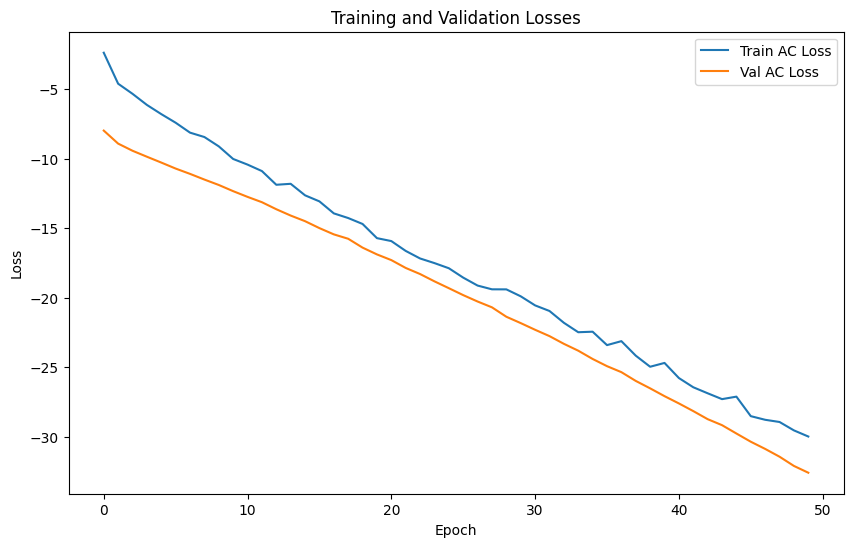

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(agent.training_ac_losses, label='Train AC Loss')
plt.plot(agent.val_ac_losses, label='Val AC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

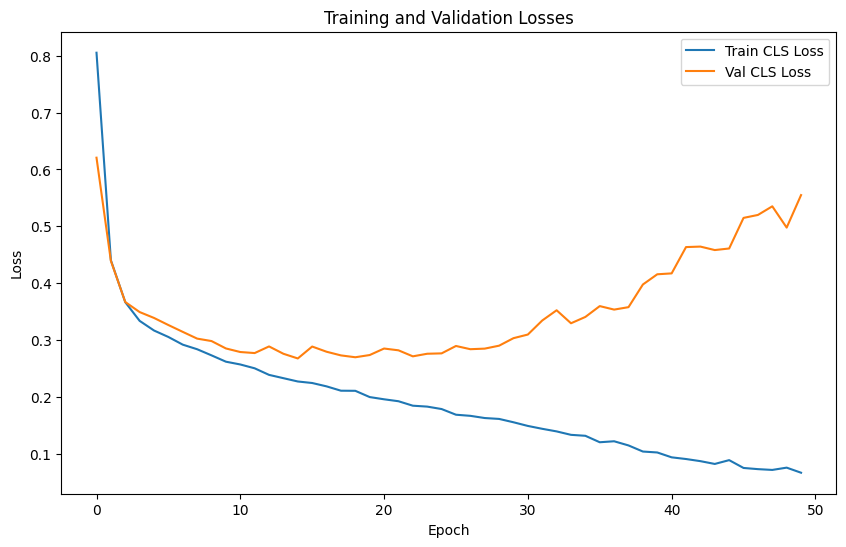

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(agent.training_classifier_losses, label='Train CLS Loss')
plt.plot(agent.val_classifier_losses, label='Val CLS Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

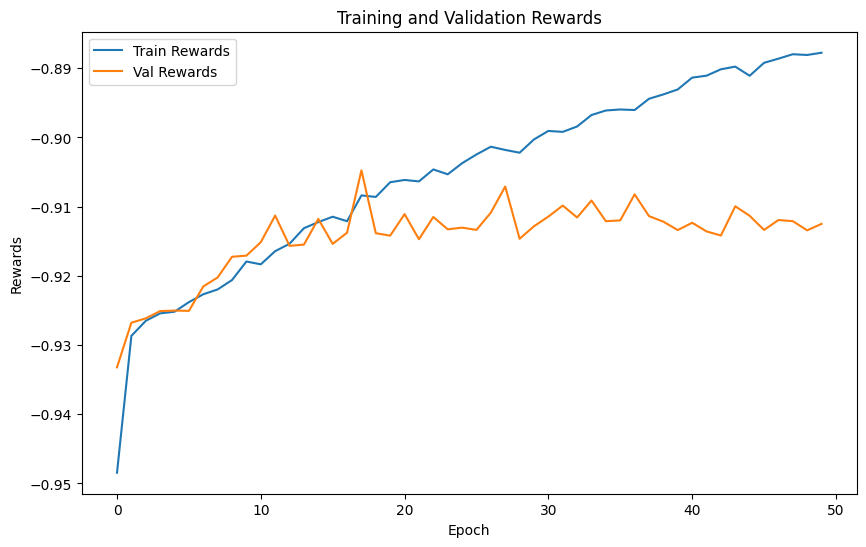

In [92]:
training_rewards = torch.tensor(agent.training_rewards)
training_rewards.tolist()
plt.figure(figsize=(10, 6))
plt.plot(training_rewards.tolist(), label='Train Rewards')
plt.plot(torch.tensor(agent.val_rewards).cpu(), label='Val Rewards')
plt.xlabel('Epoch')
plt.ylabel('Rewards')
plt.title('Training and Validation Rewards')
plt.legend()
plt.show()

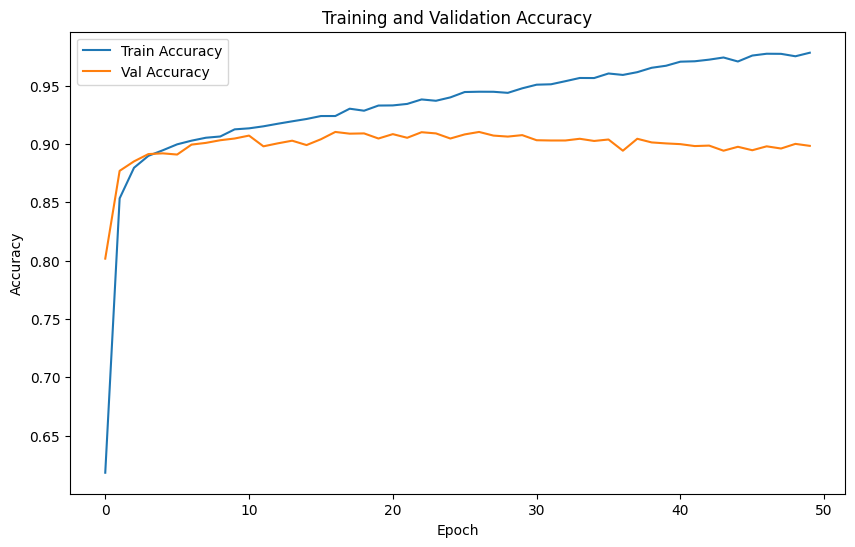

In [93]:
training_accuracy = torch.tensor(agent.training_accuracies).cpu()
val_accuracy = torch.tensor(agent.val_accuracies).cpu()
plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [21]:
def evaluate_model(actor_model, critic_classifier_model, dataloader):
    actor_model.eval()
    critic_classifier_model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for i, data in enumerate(tqdm.tqdm(dataloader), 0):
            sentence_embedding = phobert(data[0].to(device), attention_mask=data[1].to(device))[0]
            policy = actor_model(sentence_embedding)
            action = torch.argmax(policy, dim=-1)
            filtered_sentence_embedding = sentence_embedding * action.unsqueeze(-1).float()
            _, classifier_preds = critic_classifier_model(filtered_sentence_embedding)
            preds.extend(classifier_preds.argmax(dim=-1).cpu().numpy())
            labels.extend(data[2].cpu().numpy())
    return preds, labels

In [22]:
actor_net.load_state_dict(torch.load('./Model/actor_model_'+ data_name +'.pth'))
critic_classifier_net.load_state_dict(torch.load('./Model/critic_classifier_model_'+ data_name +'.pth'))

print('Test Classification Report')
test_preds, test_labels = evaluate_model(actor_net, critic_classifier_net, test_dataloader)
print(classification_report(test_labels, test_preds))

Test Classification Report


100%|██████████| 50/50 [00:05<00:00,  8.45it/s]

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1409
           1       0.52      0.34      0.41       167
           2       0.94      0.90      0.92      1590

    accuracy                           0.89      3166
   macro avg       0.78      0.73      0.75      3166
weighted avg       0.89      0.89      0.89      3166



In [23]:
actor_net.eval()
actions = []
with torch.no_grad():
    for i, data in enumerate(tqdm.tqdm(train_dataloader), 0):
        batch_sentences = data[0].to(device)
        sentence_embedding = phobert(batch_sentences, attention_mask=data[1].to(device))[0]
        policy = actor_net(sentence_embedding)
        action = torch.argmax(policy, dim=-1).squeeze()
        actions.extend(action.cpu().tolist())

100%|██████████| 179/179 [00:19<00:00,  8.96it/s]


In [24]:
action_maked = np.array(actions)
action_distribuution = np.unique(action_maked, return_counts=True)
action_distribuution_data = pd.DataFrame(action_distribuution[1], index=action_distribuution[0], columns=['count'])
action_distribuution_data

,count
1,571300


In [100]:
import phonlp

# Automatically download the pre-trained PhoNLP model for Vietnamese
# and save it in a local machine folder
# phonlp.download(save_dir='./Model/pretrained_phonlp')

# Load the pre-trained PhoNLP model for Vietnamese
model = phonlp.load(save_dir='./Model')

Loading model from: ./Model/phonlp.pt


c:\Users\royal\miniconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 45.45it/s]

1	Tôi	P	O	3	sub
2	rất	R	O	3	amod
3	đẹp	A	O	0	root
4	.	CH	O	3	punct


In [112]:
# Annotate a word-segmented sentence
model.print_out(model.annotate(text="em rất yêu trường em ."))

100%|██████████| 1/1 [00:00<00:00, 11.79it/s]

1	em	N	O	3	sub
2	rất	R	O	3	adv
3	yêu	V	O	0	root
4	trường	N	O	3	dob
5	em	N	O	4	nmod
6	.	CH	O	3	punct


In [303]:
test_sentence = torch.tensor(tokenizer('cô bé đó rất tuyệt vời', 
                                       max_length=MAX_LEN,
                                       padding='max_length',
                                       truncation=True)['input_ids'])

filter = torch.zeros_like(test_sentence).unsqueeze(0).to(device)
filter[:,:] = 1

with torch.no_grad():
    word_embedding = phobert(test_sentence.unsqueeze(0).to(device))[0]
    selected_word_embedding = word_embedding * filter.unsqueeze(-1) + torch.abs(filter.unsqueeze(-1) - 1)
    _ ,output = critic_classifier_net.forward(selected_word_embedding)
    print('Sentiment: ', output.argmax(-1).item())

Sentiment:  0


: 